# PyTorch Experiment Tracking 

what is experiment tracking?

ML and DL are very experimental.
You have to put on your artist's bereet/chef's hat to cook up lots of different models.
And you have to put on a scientist's coat to track the results of various combinations of data, model architectures and training regimes.

That's where experiment tracking comes in.
If you're running lots of different experiments, experiment tracking helps you figur out what works and what doesn't.

![image](r83gzizg.bmp)


# 0. Getting setup

Let's Download/import few modules

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.5.1+cpu
torchvision version: 0.20.1+cpu


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Get torchinfo
try:
    from torchinfo import summary
except:
    print("torchinfo not found, installing")
    %pip install -q torchinfo
    from torchinfo import summary

# Import going_modular directory, download it if doesn't exist
try:
    from going_modular import data_setup, engine
except:
    print("going_modular package not found, cloning from github")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    

In [4]:
# let's setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [5]:
# Create a helper function to set seeds
def set_seed(seed: int =42):
    """
    Sets random seeds for torch operations.
    
    Args:
        seed (int): a random seed to use.
    """
    # Set the random seed for reproducible results
    torch.manual_seed(seed)
    
    # Set the seed for CUDA torch operations 
    torch.cuda.manual_seed_all(seed)

# 1. Get data

In [6]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

# 2. Create Datasets and DataLoaders

Let's use our previously created create_dataloaders functions from going_modular directory

### 2.1 Create DataLoaders using manually created transforms

In [7]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet images)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"manual_transforms pipeline: {manual_transforms}")

# Create dataloaders
train_dataloader, test_dataloader, class_names= data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms,
    test_transform=manual_transforms,
    batch_size=32,
)

train_dataloader, test_dataloader, class_names

manual_transforms pipeline: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x1e5416b86e0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

In [8]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms used when the weights were trained)
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=automatic_transforms,
    test_transform=automatic_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1e54148af00>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [9]:
# Let's get model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup model
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
# Change the classifier head of the model

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights.
# Let's the seed
set_seed()

# Update the classifier head of the model
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True).to(device)
)

In [11]:
from torchinfo import  summary
# Get a summary of the model 
summary(
    model,
    input_size=(32,3,224,224),
    verbose=1,
    col_names=["kernel_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Kernel Shape         Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  --                   [32, 3]              --                   Partial
├─Sequential (features)                                      --                   [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              --                   [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [3, 3]               [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  --                   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         --                   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        --                   [32, 

Layer (type (var_name))                                      Kernel Shape         Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  --                   [32, 3]              --                   Partial
├─Sequential (features)                                      --                   [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              --                   [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [3, 3]               [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  --                   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         --                   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        --                   [32, 

# 4. Train model and track results

In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Adjust train() function to track results with SummaryWriter()

Beautiful!

All of the pieces of our training code are starting to come together.

Let's now add the final piece to track our experiments.

Previously, we've tracked our modelling experiments using multiple Python dictionaries (one for each model).

But you can imagine this could get out of hand if we were running anything more than a few experiments.

Not to worry, there's a better option!

We can use PyTorch's torch.utils.tensorboard.SummaryWriter() class to save various parts of our model's training progress to file.

By default, the SummaryWriter() class saves various information about our model to a file set by the log_dir parameter.

The default location for log_dir is under runs/CURRENT_DATETIME_HOSTNAME, where the HOSTNAME is the name of your computer.

But of course, you can change where your experiments are tracked (the filename is as customisable as you'd like).

The outputs of the SummaryWriter() are saved in TensorBoard format.

TensorBoard is a part of the TensorFlow deep learning library and is an excellent way to visualize different parts of your model.

To start tracking our modelling experiments, let's create a default SummaryWriter() instance.


In [13]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    %pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter
    
# Create a writer with all default settings.
writer = SummaryWriter()

we'll get the `train()` function from `engine.py` and adjust it to use `writer`

Specifically, we'll add the ability for our `train()` function to log our model's training and test loss and accuracy values.

we can do this with `writer.add_scalars(main_tag, tag_scalar_dict)`, where:
* `main_tag` (String) - the name for the scalars being tracked (e.g. "Accuracy)
* `tag_scalar_dict` (dict) - a dictionary of the values being tracked (e.g `{"train_loss": 0.3454}`)


In [14]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

# Import train() function from: 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [15]:
# Train model
# Note: Not using engine.train() since the original script isn't updated to use writer
set_seed()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8720 | test_acc: 0.7225
Epoch: 2 | train_loss: 0.8896 | train_acc: 0.6680 | test_loss: 0.7590 | test_acc: 0.8343
Epoch: 3 | train_loss: 0.8098 | train_acc: 0.6836 | test_loss: 0.7522 | test_acc: 0.7330
Epoch: 4 | train_loss: 0.6886 | train_acc: 0.8750 | test_loss: 0.6657 | test_acc: 0.8267
Epoch: 5 | train_loss: 0.6412 | train_acc: 0.7812 | test_loss: 0.6017 | test_acc: 0.8163


In [16]:
from pprint import pprint
pprint(results)

{'test_acc': [0.7225378787878788,
              0.8342803030303031,
              0.7329545454545454,
              0.8267045454545454,
              0.8162878787878788],
 'test_loss': [0.8720167676607767,
               0.7590112288792928,
               0.7522182067235311,
               0.6657437483469645,
               0.6016916235287985],
 'train_acc': [0.38671875, 0.66796875, 0.68359375, 0.875, 0.78125],
 'train_loss': [1.0965988636016846,
                0.8895912617444992,
                0.8097993060946465,
                0.6885671690106392,
                0.6412121541798115]}


# 5. View our model's results in TensorBoard



In [88]:
!kill 48144
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'kill' is not recognized as an internal or external command,
operable program or batch file.


Reusing TensorBoard on port 6006 (pid 48144), started 3:16:24 ago. (Use '!kill 48144' to kill it.)

# 6. Create a helper function to build `Summarywriter()` instances


The SummaryWriter() class logs various information to a directory specified by the log_dir parameter.

How about we make a helper function to create a custom directory per experiment?

In essence, each experiment gets its own logs directory.

For example, say we'd like to track things like:

    Experiment date/timestamp - when did the experiment take place?
    Experiment name - is there something we'd like to call the experiment?
    Model name - what model was used?
    Extra - should anything else be tracked?

You could track almost anything here and be as creative as you want but these should be enough to start.

Let's create a helper function called create_writer() that produces a SummaryWriter() instance tracking to a custom log_dir.

Ideally, we'd like the log_dir to be something like:

runs/YYYY-MM-DD/experiment_name/model_name/extra

Where YYYY-MM-DD is the date the experiment was run (you could add the time if you wanted to as well).

In [17]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [18]:
# Create an example writer
example_writer = create_writer(
    experiment_name="data_10_percent",
    model_name="effnetb0",
    extra="5_epochs"
)

[INFO] Created SummaryWriter, saving to: runs\2024-12-21\data_10_percent\effnetb0\5_epochs...


In [19]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

# 7. Setting up a series of modelling experiments


### 7. what kind of experiments should you run?

Every kind of there is no limit to it.

Such a freedom is why machine learning is so exciting and terrifying at the same time.

This is where you'll have to put on your scientist coat and remember the machine learning practitioner's motto: experiment, experiment, experiment!

Every hyperparameter stands as a starting point for a different experiment:

    Change the number of epochs.
    Change the number of layers/hidden units.
    Change the amount of data.
    Change the learning rate.
    Try different kinds of data augmentation.
    Choose a different model architecture.

With practice and running many different experiments, you'll start to build an intuition of what might help your model.

I say might on purpose because there's no guarantee.

But generally, in light of The Bitter Lesson (I've mentioned this twice now because it's an important essay in the world of AI), generally the bigger your model (more learnable parameters) and the more data you have (more opportunities to learn), the better the performance.

However, when you're first approaching a machine learning problem: start small and if something works, scale it up.

Your first batch of experiments should take no longer than a few seconds to a few minutes to run.

The quicker you can experiment, the faster you can work out what doesn't work, in turn, the faster you can work out what does work.

# 7.3 Download different datasets

In [20]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [21]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


### 7.4 Transform Datasets and create DataLoaders

In [22]:
from torchvision.models import EfficientNet_B0_Weights, efficientnet_b0, EfficientNet_B2_Weights, efficientnet_b2

# Transforms for respective weights
transforms_b0 = EfficientNet_B0_Weights.DEFAULT.transforms()

transforms_b2 = EfficientNet_B2_Weights.DEFAULT.transforms()

transforms_b0, transforms_b2

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [23]:
# setup dataloaders
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloader(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    train_transform=transforms_b0,
    test_transform=transforms_b0,
    batch_size=BATCH_SIZE
)

# Create 20% training DataLoader
train_dataloader_20_percent, test_dataloader_20_percent, _ = data_setup.create_dataloader(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    train_transform=transforms_b0,
    test_transform=transforms_b0,
    batch_size=BATCH_SIZE
)


# Find the number of samples/batches per dataloader
print(F"Number of batches in 10% training DataLoader: {len(train_dataloader_10_percent)}")
print(F"Number of batches in 20% training DataLoader: {len(train_dataloader_20_percent)}")
print(F"Number of batches in testing DataLoader: {len(test_dataloader)}")
print(F"Number of batches in 20% testing DataLoader: {len(test_dataloader_20_percent)}")
print(f"Number of classes: {len(class_names)}")

Number of batches in 10% training DataLoader: 8
Number of batches in 20% training DataLoader: 15
Number of batches in testing DataLoader: 3
Number of batches in 20% testing DataLoader: 3
Number of classes: 3


### 7.5 Create feature extractor models
Time to start building our models.

We're going to create two feature extractor models:

    torchvision.models.efficientnet_b0() pretrained backbone + custom classifier head (EffNetB0 for short).
    torchvision.models.efficientnet_b2() pretrained backbone + custom classifier head (EffNetB2 for short).

To do this, we'll freeze the base layers (the feature layers) and update the model's classifier heads (output layers) to suit our problem just like we did in 06. PyTorch Transfer Learning section 3.4.

We saw in the previous chapter the in_features parameter to the classifier head of EffNetB0 is 1280 (the backbone turns the input image into a feature vector of size 1280).

Since EffNetB2 has a different number of layers and parameters, we'll need to adapt it accordingly.

    Note: Whenever you use a different model, one of the first things you should inspect is the input and output shapes. That way you'll know how you'll have to prepare your input data/update the model to have the correct output shape.

We can find the input and output shapes of EffNetB2 using torchinfo.summary() and passing in the input_size=(32, 3, 224, 224) parameter ((32, 3, 224, 224) is equivalent to (batch_size, color_channels, height, width), i.e we pass in an example of what a single batch of data would be to our model).

    Note: Many modern models can handle input images of varying sizes thanks to torch.nn.AdaptiveAvgPool2d() layer, this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to torchinfo.summary() or to your own models using the layer.

To find the required input shape to the final layer of EffNetB2, let's:

    Create an instance of torchvision.models.efficientnet_b2(pretrained=True).
    See the various input and output shapes by running torchinfo.summary().
    Print out the number of in_features by inspecting state_dict() of the classifier portion of EffNetB2 and printing the length of the weight matrix.
        Note: You could also just inspect the output of effnetb2.classifier

In [24]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
print(summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) )

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [25]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels, eps=1e-5, affine=True):
        super(LayerNorm2d, self).__init__()
        self.layer_norm = nn.LayerNorm((num_channels, 1, 1), eps=eps, elementwise_affine=affine)

    def forward(self, x):
        # Permute dimensions: [B, C, H, W] -> [B, H, W, C] for LayerNorm
        x = x.permute(0, 2, 3, 1)
        x = self.layer_norm(x)
        # Permute back to original: [B, H, W, C] -> [B, C, H, W]
        x = x.permute(0, 3, 1, 2)
        return x

In [26]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
global OUT_FEATURES 
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seed()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seed()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create convnext_tiny feature extractor
def create_conv_tiny():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT
    model = torchvision.models.convnext_tiny(weights=weights).to(device)
    
    # 2. Freeze thee base model layers
    for param in model.features.parameters():
        param.requires_grad = False
        
    # 3. Set the seeds
    set_seed()
    
    # 4. Change the classifier head
    new_classifier = nn.Sequential(
    nn.LayerNorm((768, 1, 1), eps=1e-6, elementwise_affine=True),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Dropout(p=0.5),                                          # Dropout with 50% probability
    nn.Linear(in_features=768, out_features=100, bias=True)     # Output 100 classes
    )

    model.classifier = new_classifier

    
    # 5. Give the model a name
    model.name = "convnext_tiny"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [27]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

weights = ConvNeXt_Tiny_Weights.DEFAULT
model = convnext_tiny(weights=weights).to(device)

# summary(
#     model=model,
#     input_size=(32, 3, 224, 224),
#     verbose=1,
#     col_names=["kernel_size","input_size", "output_size", "num_params", "trainable"],
#     col_width=20,
#     row_settings=["var_names"]
# )

# model

In [28]:
effnetb0 = create_effnetb0() 

effnetb2 = create_effnetb2()

convnext_tiny = create_conv_tiny()

[INFO] Created new effnetb0 model.
[INFO] Created new effnetb2 model.
[INFO] Created new convnext_tiny model.


In [103]:
convnext_tiny

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

### 7.6 Create experiments and set up training code

In [114]:
# 1. Create epochs list
num_epochs = [5, 10, 15]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2", "convnext_tiny"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {
    "data_10_percent": train_dataloader_10_percent,
    "data_20_percent": train_dataloader_20_percent
}

In [115]:
class bcolors():
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [116]:
%%time
# Let's train 
from going_modular.utils import save_model

# 1. Set seed
set_seed()

# 2. Keep track of experiments numbers
experiment_number = 0

# 3. Loop through each Dataloader
for dataloaders_name, train_dataloader in train_dataloaders.items():
    
    # 4. Loop through each number of epochs
    for epochs in num_epochs:
        
        # 5. Loop through each model name and create a new model based on the namee
        for model_name in models:
            
            # 6. Create information print outs
            experiment_number += 1
            print(f"{bcolors.OKCYAN}{'='*50}{bcolors.ENDC}")
            print(f"{bcolors.OKCYAN}[INFO] Running experiment number: {experiment_number}{bcolors.ENDC}")
            print(f"{bcolors.OKCYAN}[INFO] Model: {model_name}")
            print(f"{bcolors.OKCYAN}[INFO] Training on: {dataloaders_name}")
            print(f"{bcolors.OKCYAN}[INFO] Training for: {epochs} epochs{bcolors.ENDC}")
            
            # 7. Create a new model based on the model_name
            if model_name == "effnetb0":
                model = create_effnetb0()
            elif model_name == "effnetb2":
                model = create_effnetb2()
            elif model_name == "convnext_tiny":
                model = create_conv_tiny()
            else:
                raise ValueError(f"Model name: {model_name} not found.")
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # 9. Create a new writer for every experiment and train target model 
            writer = create_writer(experiment_name=dataloaders_name,
                                   model_name=model_name,
                                   extra=f"{epochs}_epochs")
            
            results = train(model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=epochs,
                            device=device,
                            writer=writer)
            
            # 10. Save the model to file so we can load it later
            save_filepath = f"{model_name}_{dataloaders_name}_{epochs}_epochs.pth"
            save_model(
                model=model,
                target_dir="models",
                model_name = save_filepath
            )
            print(f"{bcolors.OKBLUE}" + "="*50 + f"{bcolors.ENDC}\n")

[INFO] Running experiment number: 1
[INFO] Model: effnetb0
[INFO] Training on: data_10_percent
[INFO] Training for: 5 epochs
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-12-21\data_10_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0552 | train_acc: 0.4805 | test_loss: 0.8657 | test_acc: 0.7216
Epoch: 2 | train_loss: 0.9103 | train_acc: 0.5820 | test_loss: 0.7748 | test_acc: 0.7424
Epoch: 3 | train_loss: 0.7614 | train_acc: 0.8398 | test_loss: 0.6966 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7605 | train_acc: 0.7109 | test_loss: 0.6433 | test_acc: 0.8248
Epoch: 5 | train_loss: 0.6179 | train_acc: 0.8750 | test_loss: 0.5297 | test_acc: 0.8854
[INFO] Saving model to: models\effnetb0_data_10_percent_5_epochs.pth

[INFO] Running experiment number: 2
[INFO] Model: effnetb2
[INFO] Training on: data_10_percent
[INFO] Training for: 5 epochs
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-12-21\data_10_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0882 | train_acc: 0.3945 | test_loss: 0.9352 | test_acc: 0.6506
Epoch: 2 | train_loss: 0.8991 | train_acc: 0.6758 | test_loss: 0.8306 | test_acc: 0.7633
Epoch: 3 | train_loss: 0.8408 | train_acc: 0.6992 | test_loss: 0.7308 | test_acc: 0.7936
Epoch: 4 | train_loss: 0.7235 | train_acc: 0.7617 | test_loss: 0.6893 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.6392 | train_acc: 0.7930 | test_loss: 0.6866 | test_acc: 0.8665
[INFO] Saving model to: models\effnetb2_data_10_percent_5_epochs.pth

[INFO] Running experiment number: 3
[INFO] Model: convnext_tiny
[INFO] Training on: data_10_percent
[INFO] Training for: 5 epochs
[INFO] Created new convnext_tiny model.
[INFO] Created SummaryWriter, saving to: runs\2024-12-21\data_10_percent\convnext_tiny\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6057 | train_acc: 0.2969 | test_loss: 1.6375 | test_acc: 0.8456
Epoch: 2 | train_loss: 1.2595 | train_acc: 0.7578 | test_loss: 0.5142 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.4882 | train_acc: 0.8750 | test_loss: 0.3349 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.3480 | train_acc: 0.8906 | test_loss: 0.2623 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.2909 | train_acc: 0.9453 | test_loss: 0.1976 | test_acc: 0.9176
[INFO] Saving model to: models\convnext_tiny_data_10_percent_5_epochs.pth

[INFO] Running experiment number: 4
[INFO] Model: effnetb0
[INFO] Training on: data_10_percent
[INFO] Training for: 10 epochs
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-12-21\data_10_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0552 | train_acc: 0.4805 | test_loss: 0.8657 | test_acc: 0.7216
Epoch: 2 | train_loss: 0.9103 | train_acc: 0.5820 | test_loss: 0.7748 | test_acc: 0.7424
Epoch: 3 | train_loss: 0.7614 | train_acc: 0.8398 | test_loss: 0.6966 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7605 | train_acc: 0.7109 | test_loss: 0.6433 | test_acc: 0.8248
Epoch: 5 | train_loss: 0.6179 | train_acc: 0.8750 | test_loss: 0.5297 | test_acc: 0.8854
Epoch: 6 | train_loss: 0.6227 | train_acc: 0.7617 | test_loss: 0.5123 | test_acc: 0.8854
Epoch: 7 | train_loss: 0.5516 | train_acc: 0.7656 | test_loss: 0.5349 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5215 | train_acc: 0.8125 | test_loss: 0.5693 | test_acc: 0.8153
Epoch: 9 | train_loss: 0.4968 | train_acc: 0.8125 | test_loss: 0.5458 | test_acc: 0.8059
Epoch: 10 | train_loss: 0.4955 | train_acc: 0.8203 | test_loss: 0.5188 | test_acc: 0.8049
[INFO] Saving model to: models\effnetb0_data_10_percent_10_epochs.pth

[INFO] Running experiment number: 5
[I

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0882 | train_acc: 0.3945 | test_loss: 0.9352 | test_acc: 0.6506
Epoch: 2 | train_loss: 0.8991 | train_acc: 0.6758 | test_loss: 0.8306 | test_acc: 0.7633
Epoch: 3 | train_loss: 0.8408 | train_acc: 0.6992 | test_loss: 0.7308 | test_acc: 0.7936
Epoch: 4 | train_loss: 0.7235 | train_acc: 0.7617 | test_loss: 0.6893 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.6392 | train_acc: 0.7930 | test_loss: 0.6866 | test_acc: 0.8665
Epoch: 6 | train_loss: 0.5712 | train_acc: 0.9453 | test_loss: 0.6153 | test_acc: 0.9062
Epoch: 7 | train_loss: 0.6403 | train_acc: 0.7734 | test_loss: 0.5776 | test_acc: 0.8655
Epoch: 8 | train_loss: 0.5479 | train_acc: 0.8086 | test_loss: 0.5800 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5814 | train_acc: 0.7930 | test_loss: 0.6099 | test_acc: 0.8665
Epoch: 10 | train_loss: 0.4875 | train_acc: 0.8008 | test_loss: 0.5317 | test_acc: 0.9072
[INFO] Saving model to: models\effnetb2_data_10_percent_10_epochs.pth

[INFO] Running experiment number: 6
[I

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6057 | train_acc: 0.2969 | test_loss: 1.6375 | test_acc: 0.8456
Epoch: 2 | train_loss: 1.2595 | train_acc: 0.7578 | test_loss: 0.5142 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.4882 | train_acc: 0.8750 | test_loss: 0.3349 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.3480 | train_acc: 0.8906 | test_loss: 0.2623 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.2909 | train_acc: 0.9453 | test_loss: 0.1976 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.3984 | train_acc: 0.8086 | test_loss: 0.1735 | test_acc: 0.9375
Epoch: 7 | train_loss: 0.2166 | train_acc: 0.9297 | test_loss: 0.2149 | test_acc: 0.8778
Epoch: 8 | train_loss: 0.1817 | train_acc: 0.9375 | test_loss: 0.1826 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.1726 | train_acc: 0.9531 | test_loss: 0.1952 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.1460 | train_acc: 0.9531 | test_loss: 0.1688 | test_acc: 0.9176
[INFO] Saving model to: models\convnext_tiny_data_10_percent_10_epochs.pth

[INFO] Running experiment number:

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0552 | train_acc: 0.4805 | test_loss: 0.8657 | test_acc: 0.7216
Epoch: 2 | train_loss: 0.9103 | train_acc: 0.5820 | test_loss: 0.7748 | test_acc: 0.7424
Epoch: 3 | train_loss: 0.7614 | train_acc: 0.8398 | test_loss: 0.6966 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7605 | train_acc: 0.7109 | test_loss: 0.6433 | test_acc: 0.8248
Epoch: 5 | train_loss: 0.6179 | train_acc: 0.8750 | test_loss: 0.5297 | test_acc: 0.8854
Epoch: 6 | train_loss: 0.6227 | train_acc: 0.7617 | test_loss: 0.5123 | test_acc: 0.8854
Epoch: 7 | train_loss: 0.5516 | train_acc: 0.7656 | test_loss: 0.5349 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5215 | train_acc: 0.8125 | test_loss: 0.5693 | test_acc: 0.8153
Epoch: 9 | train_loss: 0.4968 | train_acc: 0.8125 | test_loss: 0.5458 | test_acc: 0.8059
Epoch: 10 | train_loss: 0.4955 | train_acc: 0.8203 | test_loss: 0.5188 | test_acc: 0.8049
Epoch: 11 | train_loss: 0.4387 | train_acc: 0.8359 | test_loss: 0.4299 | test_acc: 0.8447
Epoch: 12 | train_l

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0882 | train_acc: 0.3945 | test_loss: 0.9352 | test_acc: 0.6506
Epoch: 2 | train_loss: 0.8991 | train_acc: 0.6758 | test_loss: 0.8306 | test_acc: 0.7633
Epoch: 3 | train_loss: 0.8408 | train_acc: 0.6992 | test_loss: 0.7308 | test_acc: 0.7936
Epoch: 4 | train_loss: 0.7235 | train_acc: 0.7617 | test_loss: 0.6893 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.6392 | train_acc: 0.7930 | test_loss: 0.6866 | test_acc: 0.8665
Epoch: 6 | train_loss: 0.5712 | train_acc: 0.9453 | test_loss: 0.6153 | test_acc: 0.9062
Epoch: 7 | train_loss: 0.6403 | train_acc: 0.7734 | test_loss: 0.5776 | test_acc: 0.8655
Epoch: 8 | train_loss: 0.5479 | train_acc: 0.8086 | test_loss: 0.5800 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5814 | train_acc: 0.7930 | test_loss: 0.6099 | test_acc: 0.8665
Epoch: 10 | train_loss: 0.4875 | train_acc: 0.8008 | test_loss: 0.5317 | test_acc: 0.9072
Epoch: 11 | train_loss: 0.5066 | train_acc: 0.8281 | test_loss: 0.4926 | test_acc: 0.8561
Epoch: 12 | train_l

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6057 | train_acc: 0.2969 | test_loss: 1.6375 | test_acc: 0.8456
Epoch: 2 | train_loss: 1.2595 | train_acc: 0.7578 | test_loss: 0.5142 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.4882 | train_acc: 0.8750 | test_loss: 0.3349 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.3480 | train_acc: 0.8906 | test_loss: 0.2623 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.2909 | train_acc: 0.9453 | test_loss: 0.1976 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.3984 | train_acc: 0.8086 | test_loss: 0.1735 | test_acc: 0.9375
Epoch: 7 | train_loss: 0.2166 | train_acc: 0.9297 | test_loss: 0.2149 | test_acc: 0.8778
Epoch: 8 | train_loss: 0.1817 | train_acc: 0.9375 | test_loss: 0.1826 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.1726 | train_acc: 0.9531 | test_loss: 0.1952 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.1460 | train_acc: 0.9531 | test_loss: 0.1688 | test_acc: 0.9176
Epoch: 11 | train_loss: 0.1385 | train_acc: 0.9609 | test_loss: 0.1987 | test_acc: 0.9176
Epoch: 12 | train_l

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9627 | train_acc: 0.5500 | test_loss: 0.6635 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.6942 | train_acc: 0.8042 | test_loss: 0.5231 | test_acc: 0.9583
Epoch: 3 | train_loss: 0.5769 | train_acc: 0.8146 | test_loss: 0.4842 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.4547 | train_acc: 0.8938 | test_loss: 0.3915 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.4205 | train_acc: 0.8625 | test_loss: 0.4027 | test_acc: 0.8570
[INFO] Saving model to: models\effnetb0_data_20_percent_5_epochs.pth

[INFO] Running experiment number: 11
[INFO] Model: effnetb2
[INFO] Training on: data_20_percent
[INFO] Training for: 5 epochs
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2024-12-21\data_20_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0002 | train_acc: 0.5042 | test_loss: 0.7798 | test_acc: 0.8958
Epoch: 2 | train_loss: 0.7403 | train_acc: 0.8187 | test_loss: 0.6761 | test_acc: 0.8570
Epoch: 3 | train_loss: 0.6055 | train_acc: 0.8458 | test_loss: 0.5781 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.5573 | train_acc: 0.8667 | test_loss: 0.5171 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.5214 | train_acc: 0.8375 | test_loss: 0.4478 | test_acc: 0.9583
[INFO] Saving model to: models\effnetb2_data_20_percent_5_epochs.pth

[INFO] Running experiment number: 12
[INFO] Model: convnext_tiny
[INFO] Training on: data_20_percent
[INFO] Training for: 5 epochs
[INFO] Created new convnext_tiny model.
[INFO] Created SummaryWriter, saving to: runs\2024-12-21\data_20_percent\convnext_tiny\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5958 | train_acc: 0.4479 | test_loss: 0.4959 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.4578 | train_acc: 0.8688 | test_loss: 0.2366 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.2886 | train_acc: 0.9250 | test_loss: 0.1918 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.2105 | train_acc: 0.9375 | test_loss: 0.1599 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.1640 | train_acc: 0.9542 | test_loss: 0.1466 | test_acc: 0.9375
[INFO] Saving model to: models\convnext_tiny_data_20_percent_5_epochs.pth

[INFO] Running experiment number: 13
[INFO] Model: effnetb0
[INFO] Training on: data_20_percent
[INFO] Training for: 10 epochs
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2024-12-21\data_20_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9627 | train_acc: 0.5500 | test_loss: 0.6635 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.6942 | train_acc: 0.8042 | test_loss: 0.5231 | test_acc: 0.9583
Epoch: 3 | train_loss: 0.5769 | train_acc: 0.8146 | test_loss: 0.4842 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.4547 | train_acc: 0.8938 | test_loss: 0.3915 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.4205 | train_acc: 0.8625 | test_loss: 0.4027 | test_acc: 0.8570
Epoch: 6 | train_loss: 0.4068 | train_acc: 0.8771 | test_loss: 0.3303 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3407 | train_acc: 0.9187 | test_loss: 0.3160 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3860 | train_acc: 0.9042 | test_loss: 0.3628 | test_acc: 0.8674
Epoch: 9 | train_loss: 0.3947 | train_acc: 0.8458 | test_loss: 0.3140 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.3649 | train_acc: 0.8938 | test_loss: 0.2794 | test_acc: 0.9479
[INFO] Saving model to: models\effnetb0_data_20_percent_10_epochs.pth

[INFO] Running experiment number: 14
[

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0002 | train_acc: 0.5042 | test_loss: 0.7798 | test_acc: 0.8958
Epoch: 2 | train_loss: 0.7403 | train_acc: 0.8187 | test_loss: 0.6761 | test_acc: 0.8570
Epoch: 3 | train_loss: 0.6055 | train_acc: 0.8458 | test_loss: 0.5781 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.5573 | train_acc: 0.8667 | test_loss: 0.5171 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.5214 | train_acc: 0.8375 | test_loss: 0.4478 | test_acc: 0.9583
Epoch: 6 | train_loss: 0.4500 | train_acc: 0.8500 | test_loss: 0.3920 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.3955 | train_acc: 0.9083 | test_loss: 0.3981 | test_acc: 0.9583
Epoch: 8 | train_loss: 0.3480 | train_acc: 0.9208 | test_loss: 0.4453 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3609 | train_acc: 0.9146 | test_loss: 0.3305 | test_acc: 0.9583
Epoch: 10 | train_loss: 0.3636 | train_acc: 0.9125 | test_loss: 0.3347 | test_acc: 0.9375
[INFO] Saving model to: models\effnetb2_data_20_percent_10_epochs.pth

[INFO] Running experiment number: 15
[

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5958 | train_acc: 0.4479 | test_loss: 0.4959 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.4578 | train_acc: 0.8688 | test_loss: 0.2366 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.2886 | train_acc: 0.9250 | test_loss: 0.1918 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.2105 | train_acc: 0.9375 | test_loss: 0.1599 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.1640 | train_acc: 0.9542 | test_loss: 0.1466 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.2186 | train_acc: 0.9271 | test_loss: 0.1768 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.1532 | train_acc: 0.9729 | test_loss: 0.1886 | test_acc: 0.9081
Epoch: 8 | train_loss: 0.1180 | train_acc: 0.9667 | test_loss: 0.1332 | test_acc: 0.9479
Epoch: 9 | train_loss: 0.1222 | train_acc: 0.9604 | test_loss: 0.1501 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.1174 | train_acc: 0.9688 | test_loss: 0.1965 | test_acc: 0.9081
[INFO] Saving model to: models\convnext_tiny_data_20_percent_10_epochs.pth

[INFO] Running experiment number:

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9627 | train_acc: 0.5500 | test_loss: 0.6635 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.6942 | train_acc: 0.8042 | test_loss: 0.5231 | test_acc: 0.9583
Epoch: 3 | train_loss: 0.5769 | train_acc: 0.8146 | test_loss: 0.4842 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.4547 | train_acc: 0.8938 | test_loss: 0.3915 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.4205 | train_acc: 0.8625 | test_loss: 0.4027 | test_acc: 0.8570
Epoch: 6 | train_loss: 0.4068 | train_acc: 0.8771 | test_loss: 0.3303 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3407 | train_acc: 0.9187 | test_loss: 0.3160 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3860 | train_acc: 0.9042 | test_loss: 0.3628 | test_acc: 0.8674
Epoch: 9 | train_loss: 0.3947 | train_acc: 0.8458 | test_loss: 0.3140 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.3649 | train_acc: 0.8938 | test_loss: 0.2794 | test_acc: 0.9479
Epoch: 11 | train_loss: 0.3761 | train_acc: 0.8562 | test_loss: 0.2738 | test_acc: 0.9176
Epoch: 12 | train_l

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0002 | train_acc: 0.5042 | test_loss: 0.7798 | test_acc: 0.8958
Epoch: 2 | train_loss: 0.7403 | train_acc: 0.8187 | test_loss: 0.6761 | test_acc: 0.8570
Epoch: 3 | train_loss: 0.6055 | train_acc: 0.8458 | test_loss: 0.5781 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.5573 | train_acc: 0.8667 | test_loss: 0.5171 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.5214 | train_acc: 0.8375 | test_loss: 0.4478 | test_acc: 0.9583
Epoch: 6 | train_loss: 0.4500 | train_acc: 0.8500 | test_loss: 0.3920 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.3955 | train_acc: 0.9083 | test_loss: 0.3981 | test_acc: 0.9583
Epoch: 8 | train_loss: 0.3480 | train_acc: 0.9208 | test_loss: 0.4453 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3609 | train_acc: 0.9146 | test_loss: 0.3305 | test_acc: 0.9583
Epoch: 10 | train_loss: 0.3636 | train_acc: 0.9125 | test_loss: 0.3347 | test_acc: 0.9375
Epoch: 11 | train_loss: 0.3275 | train_acc: 0.9167 | test_loss: 0.3280 | test_acc: 0.9176
Epoch: 12 | train_l

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5958 | train_acc: 0.4479 | test_loss: 0.4959 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.4578 | train_acc: 0.8688 | test_loss: 0.2366 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.2886 | train_acc: 0.9250 | test_loss: 0.1918 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.2105 | train_acc: 0.9375 | test_loss: 0.1599 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.1640 | train_acc: 0.9542 | test_loss: 0.1466 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.2186 | train_acc: 0.9271 | test_loss: 0.1768 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.1532 | train_acc: 0.9729 | test_loss: 0.1886 | test_acc: 0.9081
Epoch: 8 | train_loss: 0.1180 | train_acc: 0.9667 | test_loss: 0.1332 | test_acc: 0.9479
Epoch: 9 | train_loss: 0.1222 | train_acc: 0.9604 | test_loss: 0.1501 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.1174 | train_acc: 0.9688 | test_loss: 0.1965 | test_acc: 0.9081
Epoch: 11 | train_loss: 0.1016 | train_acc: 0.9750 | test_loss: 0.1494 | test_acc: 0.9280
Epoch: 12 | train_l

# 8. View Experiments in TensorBoard

In [117]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

# 8. Load in the best model and make predictions with it

Looking at the TensorBoard logs for our eight experiments, it seems experiment convnext_tiny model with epoch 15 achieved achieved the best overall results

In [29]:
# Setup the best model filepath
best_model_path = "models/convnext_tiny_data_20_percent_15_epochs.pth"

# Instantiate a new instance of convnext tiny (to load the saved state_dict() to)
best_model = create_conv_tiny()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path, weights_only=True))

[INFO] Created new convnext_tiny model.


<All keys matched successfully>

In [30]:
# Check the modeel file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
convnext_tiny_model_size = Path(best_model_path).stat().st_size // (1024*1024)

print(f"ConvNeXt_Tiny Feature extractor model size: {convnext_tiny_model_size}")

ConvNeXt_Tiny Feature extractor model size: 106


In [81]:
from typing import Tuple
from PIL import Image

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    # Extract the scalar value from the tensor
    predicted_class = target_image_pred_label.item()
    print(f"Predicted class: {predicted_class}")
    print(f"Predicted class name: {class_names[predicted_class]}")
    print(f"Predicted class probability: {target_image_pred_probs.max().item()}")
    plt.title(
        f"Pred: {class_names[predicted_class]} | Prob: {target_image_pred_probs.max():.3f}"
    )

    plt.axis(False)

Predicted class: 2
Predicted class name: sushi
Predicted class probability: 0.9649856686592102
Predicted class: 1
Predicted class name: steak
Predicted class probability: 0.99714595079422
Predicted class: 2
Predicted class name: sushi
Predicted class probability: 0.9458639025688171


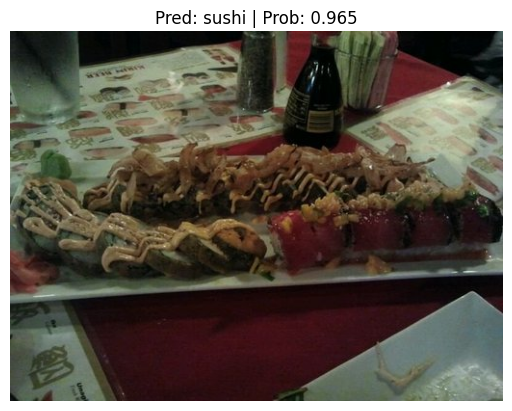

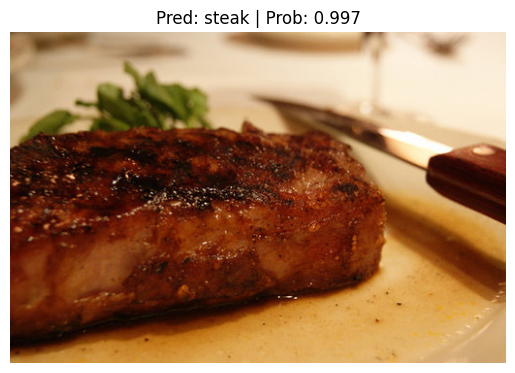

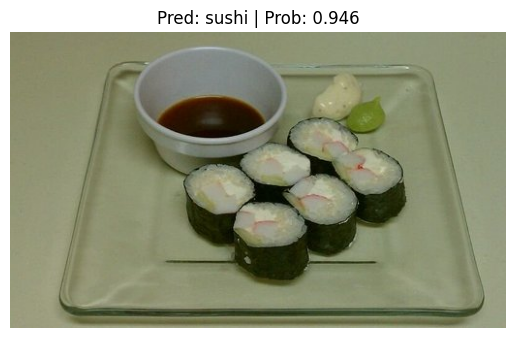

In [82]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

### 9.1 Predict on custom image with the best model


data\04-pizza-dad.jpeg already exists, skipping download.
Predicted class: 0
Predicted class name: pizza
Predicted class probability: 0.9996823072433472


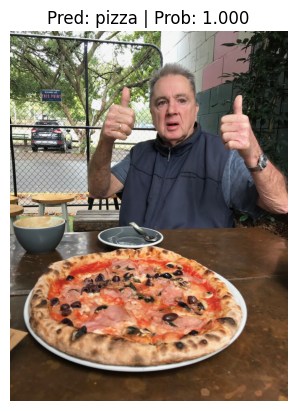

In [84]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

from torchvision.models import ConvNeXt_Tiny_Weights

transformation = ConvNeXt_Tiny_Weights.DEFAULT.transforms()

# Predict on custom image
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=transformation,
                    image_size=(224, 224))